# Week 6 - Machine learning by example

### Motivation

The techniques from Lecture 5 depend upon making some (often stringent) assumptions about the underlying generative mechanisms and their error distributions in order to draw meaningful conclusions. In one view, machine learning is a toolkit of techniques for describing data or making predicitons by assuming somewhat less about the statistical mechanisms that are generating our data: instead, we squeeze the most out of the data we've already got to make assertions that will generalise to data unseen.

### Aims

- Demystify some of the ideas behind machine learning by getting hands-on with data from a [nature machine intelligence](https://www.nature.com/natmachintell/) paper, ["An interpretable mortality prediction model for COVID-19 patients"](https://www.nature.com/articles/s42256-020-0180-7).
- Acquire basic familiarity with Python tools for machine learning.

### Learning objectives

- Acquire a basic familiarity with the language of machine learning (ML/data mining/AI/pattern recognition/statistics, unsupervised vs. supervised learning, classification and regression, train/test split, bias/variance tradeoff (generalisability), ...)
- Implement an end-to-end machine learning classification model using the scikit-learn framework.
- Know how to report on the effectiveness of a machine learning model



## 0. Setup

You will need to install the [pandas](https://pandas.pydata.org/), [scikit-learn](https://scikit-learn.org/stable/), [xgboost](https://xgboost.readthedocs.io/en/latest/get_started.html), [matplotlib](https://matplotlib.org/),[seaborn](https://seaborn.pydata.org/) and [yellowbrick](https://www.scikit-yb.org/en/latest/index.html) packages to run this notebook, and you'll require Python >=3.6.

 To install these packages, launch the "Anaconda Prompt (Anaconda3)" program and run the following commands:

`conda install -c anaconda pandas scikit-learn seaborn`

`conda install -c anaconda xgboost matplotlib`

`conda install -c districtdatalabs yellowbrick`

<img src="../img/AZ_conda_prompt.png">


### (Optionally) Training data

The original training datasets for the paper are linked as [Supplementary data](https://static-content.springer.com/esm/art%3A10.1038%2Fs42256-020-0180-7/MediaObjects/42256_2020_180_MOESM3_ESM.zip). You don't have to download this since we have included the single Excel file we need for this example as `data/time_series_375_preprocess_en.xlsx` in this project.



In [30]:
import datetime

import pandas as pd

In [31]:
TRAIN_PATH = '../data/time_series_375_preprocess_en.xlsx'
RANDOM_SEED=42

## 1. Load data from Excel



In [52]:
def load_training_data(path):
    """ Load Excel sheet of measurements from patients (timepandas.DataFrame with MultiIndex ['PATIENT_ID', 'RE_DATE'] (the unique patient identifier and patient sample date, corresponding to columns [0,1] respectively of the loaded worksheet), then retain the last set of measurements made per patient, drop 'Admission time', 'Discharge time', 'gender' and 'age' features, and replace NaNs with -1. 
    """

    # Specify explicitly what columns we want to load and what their data types are expected to be.
    DTYPES = {
        'PATIENT_ID': int,
        'RE_DATE': str,
        'age': int,
        'gender': int,
        'Admission time': str,
        'Discharge time': str,
        'outcome': float,
        'Hypersensitive cardiac troponinI': float,
        'hemoglobin': float,
        'Serum chloride': float,
        'Prothrombin time': float,
        'procalcitonin': float,
        'eosinophils(%)': float,
        'Interleukin 2 receptor': float,
        'Alkaline phosphatase': float,
        'albumin': float,
        'basophil(%)': float,
        'Interleukin 10': float,
        'Total bilirubin': float,
        'Platelet count': float,
        'monocytes(%)': float,
        'antithrombin': float,
        'Interleukin 8': float,
        'indirect bilirubin': float,
        'Red blood cell distribution width': float,
        'neutrophils(%)': float,
        'total protein': float,
        'Quantification of Treponema pallidum antibodies': float,
        'Prothrombin activity': float,
        'HBsAg': float,
        'mean corpuscular volume': float,
        'hematocrit': float,
        'White blood cell count': float,
        'Tumor necrosis factorα': float,
        'mean corpuscular hemoglobin concentration': float,
        'fibrinogen': float,
        'Interleukin 1β': float,
        'Urea': float,
        'lymphocyte count': float,
        'PH value': float,
        'Red blood cell count': float,
        'Eosinophil count': float,
        'Corrected calcium': float,
        'Serum potassium': float,
        'glucose': float,
        'neutrophils count': float,
        'Direct bilirubin': float,
        'Mean platelet volume': float,
        'ferritin': float,
        'RBC distribution width SD': float,
        'Thrombin time': float,
        '(%)lymphocyte': float,
        'HCV antibody quantification': float,
        'D-D dimer': float,
        'Total cholesterol': float,
        'aspartate aminotransferase': float,
        'Uric acid': float,
        'HCO3-': float,
        'calcium': float,
        'Amino-terminal brain natriuretic peptide precursor(NT-proBNP)': float,
        'Lactate dehydrogenase': float,
        'platelet large cell ratio ': float,
        'Interleukin 6': float,
        'Fibrin degradation products': float,
        'monocytes count': float,
        'PLT distribution width': float,
        'globulin': float,
        'γ-glutamyl transpeptidase': float,
        'International standard ratio': float,
        'basophil count(#)': float,
        '2019-nCoV nucleic acid detection': float,
        'mean corpuscular hemoglobin': float,
        'Activation of partial thromboplastin time': float,
        'High sensitivity C-reactive protein': float,
        'HIV antibody quantification': float,
        'serum sodium': float,
        'thrombocytocrit': float,
        'ESR': float,
        'glutamic-pyruvic transaminase': float,
        'eGFR': float,
        'creatinine': float
    }

    # Specify which string columns should be interpreted as datetimes.
    DATETIME_COLUMNS = ['RE_DATE', 'Admission time', 'Discharge time']
    
    return (
        pd.read_excel(path, index_col=[0,1], dtype=DTYPES, parse_dates=DATETIME_COLUMNS)
            .sort_index()
            .groupby('PATIENT_ID').last()
            .drop(['Admission time', 'Discharge time'], axis=1)
            .drop(['age', 'gender'], axis=1) # removed in later preprocessing step in original paper
            #.fillna(-1) # Erratum: this was previously included here, negating the action of the remove_columns_with_missing_data funciton below.
    )

In [53]:
def remove_columns_with_missing_data(df, threshold=0.8):
    """ Remove all columns from DataFrame df where the proportion of missing records is greater than threshold.
    """
    # Note: in Pandas >=1.0.0, you can use `data_df = data_df.dropna(axis=1, threshold=0.2*len(data_df))`
    keep_cols = df.isnull().sum() <= threshold*len(df)
    return df.loc[:,keep_cols]

In [34]:
data = load_training_data(path=TRAIN_PATH)
print(data.shape)
data.head()

(375, 75)


,outcome,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,albumin,...,mean corpuscular hemoglobin,Activation of partial thromboplastin time,High sensitivity C-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
1,0.0,19.9,131.0,100.0,12.4,0.09,1.7,-1.0,71.0,37.6,...,32.3,38.9,2.6,0.09,142.7,0.16,41.0,30.0,74.7,88.0
2,0.0,1.9,149.0,98.1,12.3,0.09,0.1,441.0,45.0,37.2,...,32.2,36.0,27.4,-1.00,137.4,0.27,40.0,22.0,94.6,74.0
3,0.0,-1.0,126.0,102.2,13.6,0.06,0.1,591.0,69.0,38.4,...,33.3,34.8,3.6,0.10,143.2,0.23,29.0,67.0,84.6,64.0
4,0.0,4.8,103.0,103.1,16.3,0.38,2.5,-1.0,79.0,34.1,...,39.2,-1.0,14.5,0.11,144.2,0.27,72.0,26.0,74.2,88.0
5,0.0,5.6,130.0,102.2,14.6,0.02,3.0,258.0,84.0,39.5,...,30.0,-1.0,0.8,0.08,143.6,0.36,11.0,18.0,122.8,54.0


In [54]:
data = remove_columns_with_missing_data(data).fillna(-1)
x = data.drop('outcome', axis=1)
y = data.outcome

## 1. Split data into training and testing sets

In [36]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=RANDOM_SEED)

## 2. Train an XGBoost model

In [37]:
import xgboost

xgboost_params = {
    'max_depth': 4, # How deep do we allow the individual decision trees?
    'learning_rate': 0.2, # How much is each additional tree allowed to optimise the current fit?
    'reg_lambda': 1, # How do we restrict the fit model by penalising its complexity?
    'n_estimators': 150, # How many trees in the forest?
    'subsample': 0.9, # Proportion of rows of the training data to sample for each new tree.
    'colsample_bytree': 0.9, # Proportion of columns of the training data to sample for each new tree.
    'seed': RANDOM_SEED
}
xgboost_classifier = xgboost.XGBClassifier(**xgboost_params)
xgboost_classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.9, verbosity=1)

### Order the features by their importance to the model (a few Python tricks here to unpack!)

Here we essentially establish the main finding of the Nature paper!

In [38]:
feature_names, feature_importances = zip(*sorted(
    zip(x.columns, xgboost_classifier.feature_importances_),
    key=lambda _: _[1],
    reverse=True
))

In [39]:
feature_names[0:10], feature_importances[0:10]

(('Lactate dehydrogenase',
  'eosinophils(%)',
  'Alkaline phosphatase',
  'Prothrombin activity',
  'RBC distribution width SD',
  '(%)lymphocyte',
  'serum sodium',
  'Serum chloride',
  'procalcitonin',
  'Direct bilirubin'),
 (0.25716528,
  0.06594632,
  0.059787437,
  0.050469335,
  0.04595436,
  0.043953758,
  0.042437024,
  0.042027954,
  0.03675603,
  0.029303309))

### NOTE

If you get font errors with the below, resolve this issue with Matplotlib not finding basic fonts on MacOS. First install mscorefonts:
```
  > conda install -c conda-forge -y mscorefonts`
```

then within the notebook:
```
  import matplotlib
  matplotlib.font_manager._rebuild()
```

In [40]:
import matplotlib.pyplot as plt
import seaborn

def plot_features_horizontal_bar(feature_names, values, values_axis_label, top_n=10, color=None):
    g = seaborn.barplot(
        x=list(values[:top_n]),
        y=list(feature_names[:top_n]),
        orient='h',
        color=color
    )
    g.set_xlabel(values_axis_label, fontsize=14)
    g.set_ylabel("Features", fontsize=14)
    g.tick_params(labelsize=12)
    seaborn.despine()

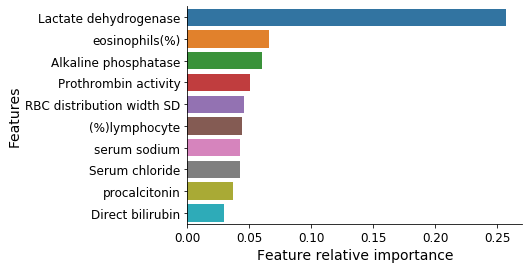

In [41]:
plot_features_horizontal_bar(
    feature_names=feature_names,
    values=feature_importances,
    values_axis_label="Feature relative importance"
)

## 3. Interrogate our model

Consider the optimal number of features to include to evaluate the predictive power of the model. Conduct a series of StratifiedKFold cross-validations to determine the optimal set of features to include. (Empirically answer 'how many features is best?' by looking at our average performance over different cuts of out-of-sample data.)

### Assessing a binary classifier

There a numerous metrics we can use to assess the performance of our model. Often, we are interested in quantities that can be derived from the `confusion matrix`: accuracy (sometimes called emprical risk), precision, recall, F1 (the harmonic mean of precision and recall), and AUC ('area under (ROC) curve').

We will look at each of these evaluated on our test set above, using Yellowbrick to help with the visualisation.

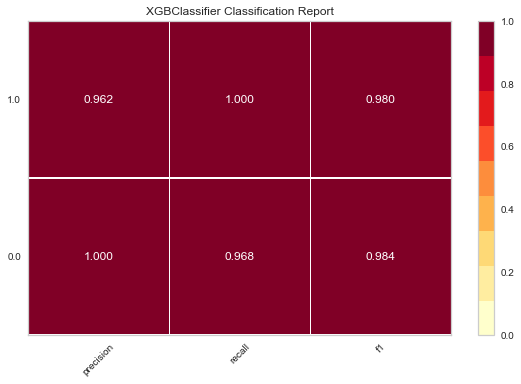

In [42]:
import yellowbrick as yb

visualizer = yb.classifier.ClassificationReport(model=xgboost_classifier)
visualizer.score(x_test, y_test)
visualizer.show()

In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

def mean_kfold_auc_scores(x, y, xgboost_params):
    auc_scores = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_indices, test_indices in skf.split(x,y):
        x_train, y_train = x[train_indices, :], y[train_indices]
        x_test, y_test = x[test_indices, :], y[test_indices]
        
        model = xgboost.XGBClassifier(**xgboost_params).fit(x_train, y_train)
        
        y_hat = model.predict(x_test)
        auc_scores.append(roc_auc_score(y_test, y_hat))
    
    return sum(auc_scores)/len(auc_scores)

In [44]:
auc_scores = [
    mean_kfold_auc_scores(x=x.values[:,:n_features+1], y=y.values, xgboost_params=xgboost_params)
    for n_features in range(len(feature_names))
]

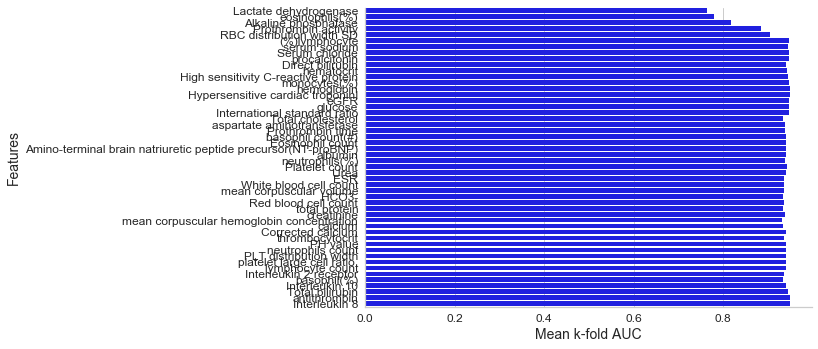

In [45]:
plot_features_horizontal_bar(
    feature_names=feature_names,
    values=auc_scores,
    values_axis_label="Mean k-fold AUC",
    top_n=50,
    color='blue'
)

### Is XGBoost really necessary?

A comparison with other methods (especially a (regularised) linear model or even a constant model as baseline) often helps to judge whether the more powerful algorithm is really neccessary. Let's compare the performance to a standard decision tree, a non-boosted random forest classifier, and (regularised) regression.

In [46]:
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [47]:
models = [
    ('XGBoost', xgboost_classifier),
    ('Decision tree', tree.DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=4)),
    ('Random forest', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=150, max_depth=4,)),
    ('Logistic regression', linear_model.LogisticRegression(random_state=RANDOM_SEED, solver='lbfgs')),
    ('Logistic regression (regularized)', linear_model.LogisticRegression(random_state=RANDOM_SEED, C=0.1,  solver='lbfgs'))
]
    

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(y, y_hat_prob, label, ax):
    false_positive_rate, true_positive_rate, _ = roc_curve(y, y_hat_prob)
    roc_auc = roc_auc_score(y, y_hat_prob)
    ax.plot(false_positive_rate, true_positive_rate, label=f'{label} (AUC: {roc_auc})')

In [49]:
def plot_roc_for_models(models, x_train, y_train, x_test, y_test, title):
    fig = plt.figure(dpi=400,figsize=(16, 8))
    ax = fig.add_subplot(111)
    
    for model_name, model in models:
        model.fit(x_train, y_train)
        y_hat_prob = model.predict_proba(x_test)[:,1]
        plot_roc(y=y_test, y_hat_prob=y_hat_prob, label=model_name, ax=ax)

    plt.title(title)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)  
    plt.legend(fontsize=14)

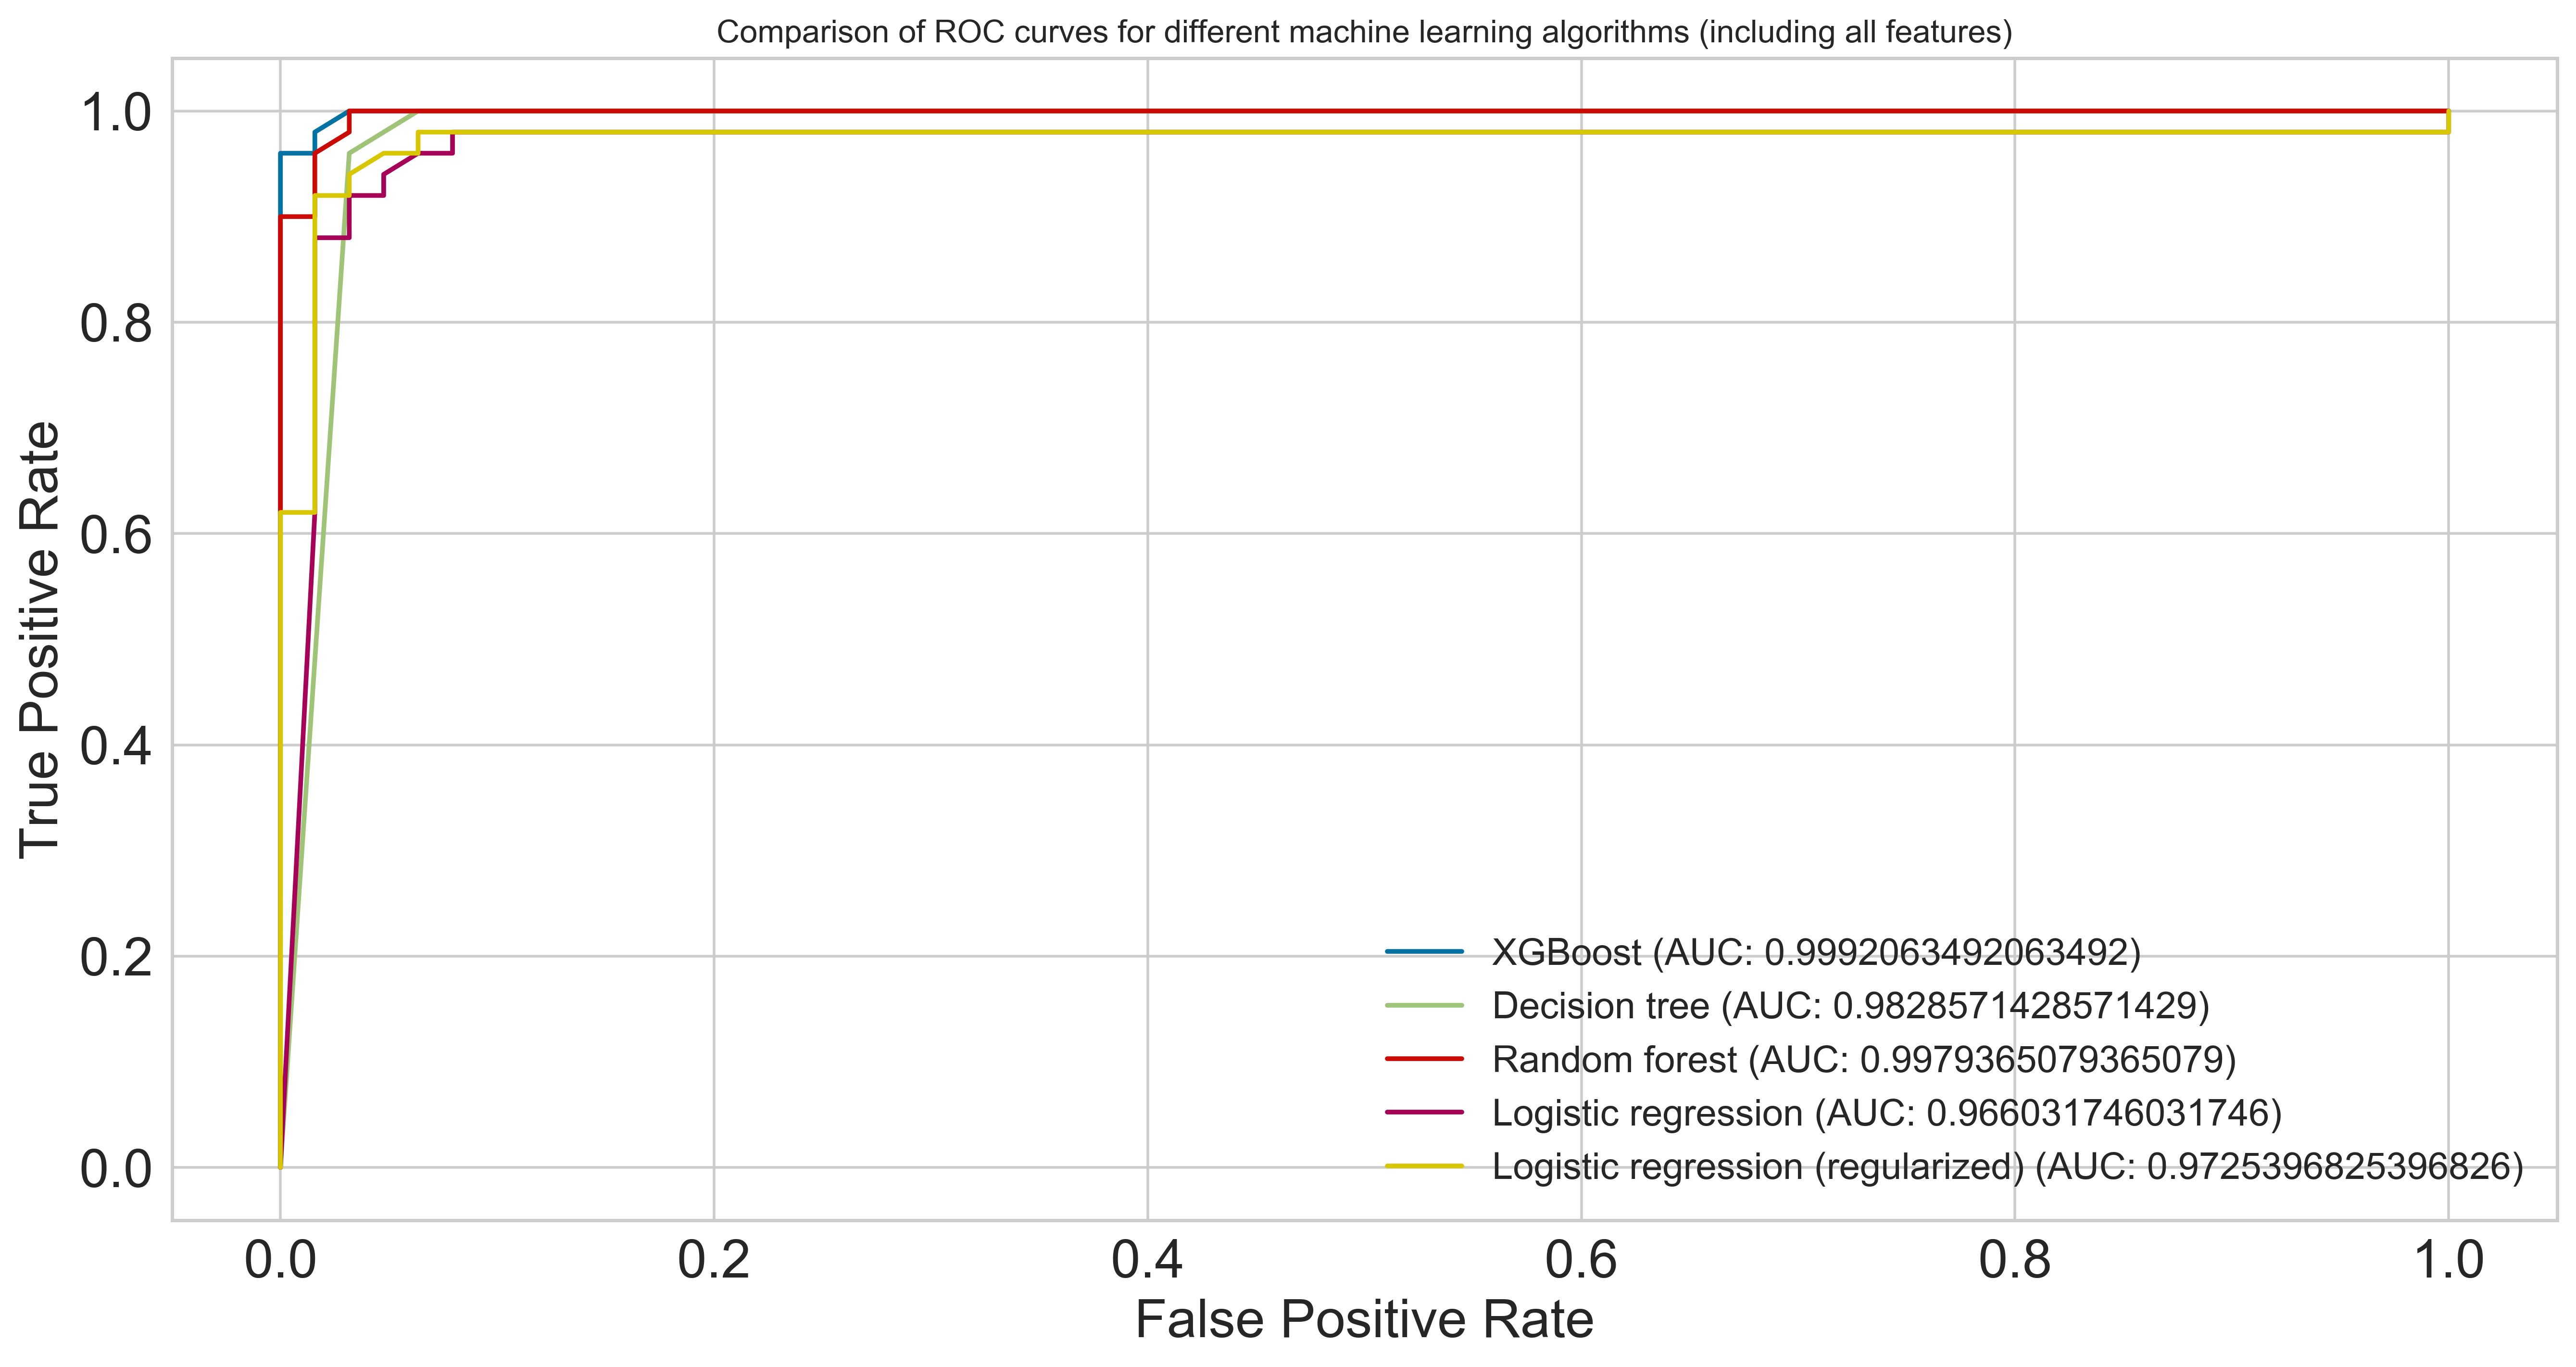

In [50]:
plot_roc_for_models(
    models=models,
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    title='Comparison of ROC curves for different machine learning algorithms (including all features)'
)

When we restrict to the 5 most informative features.

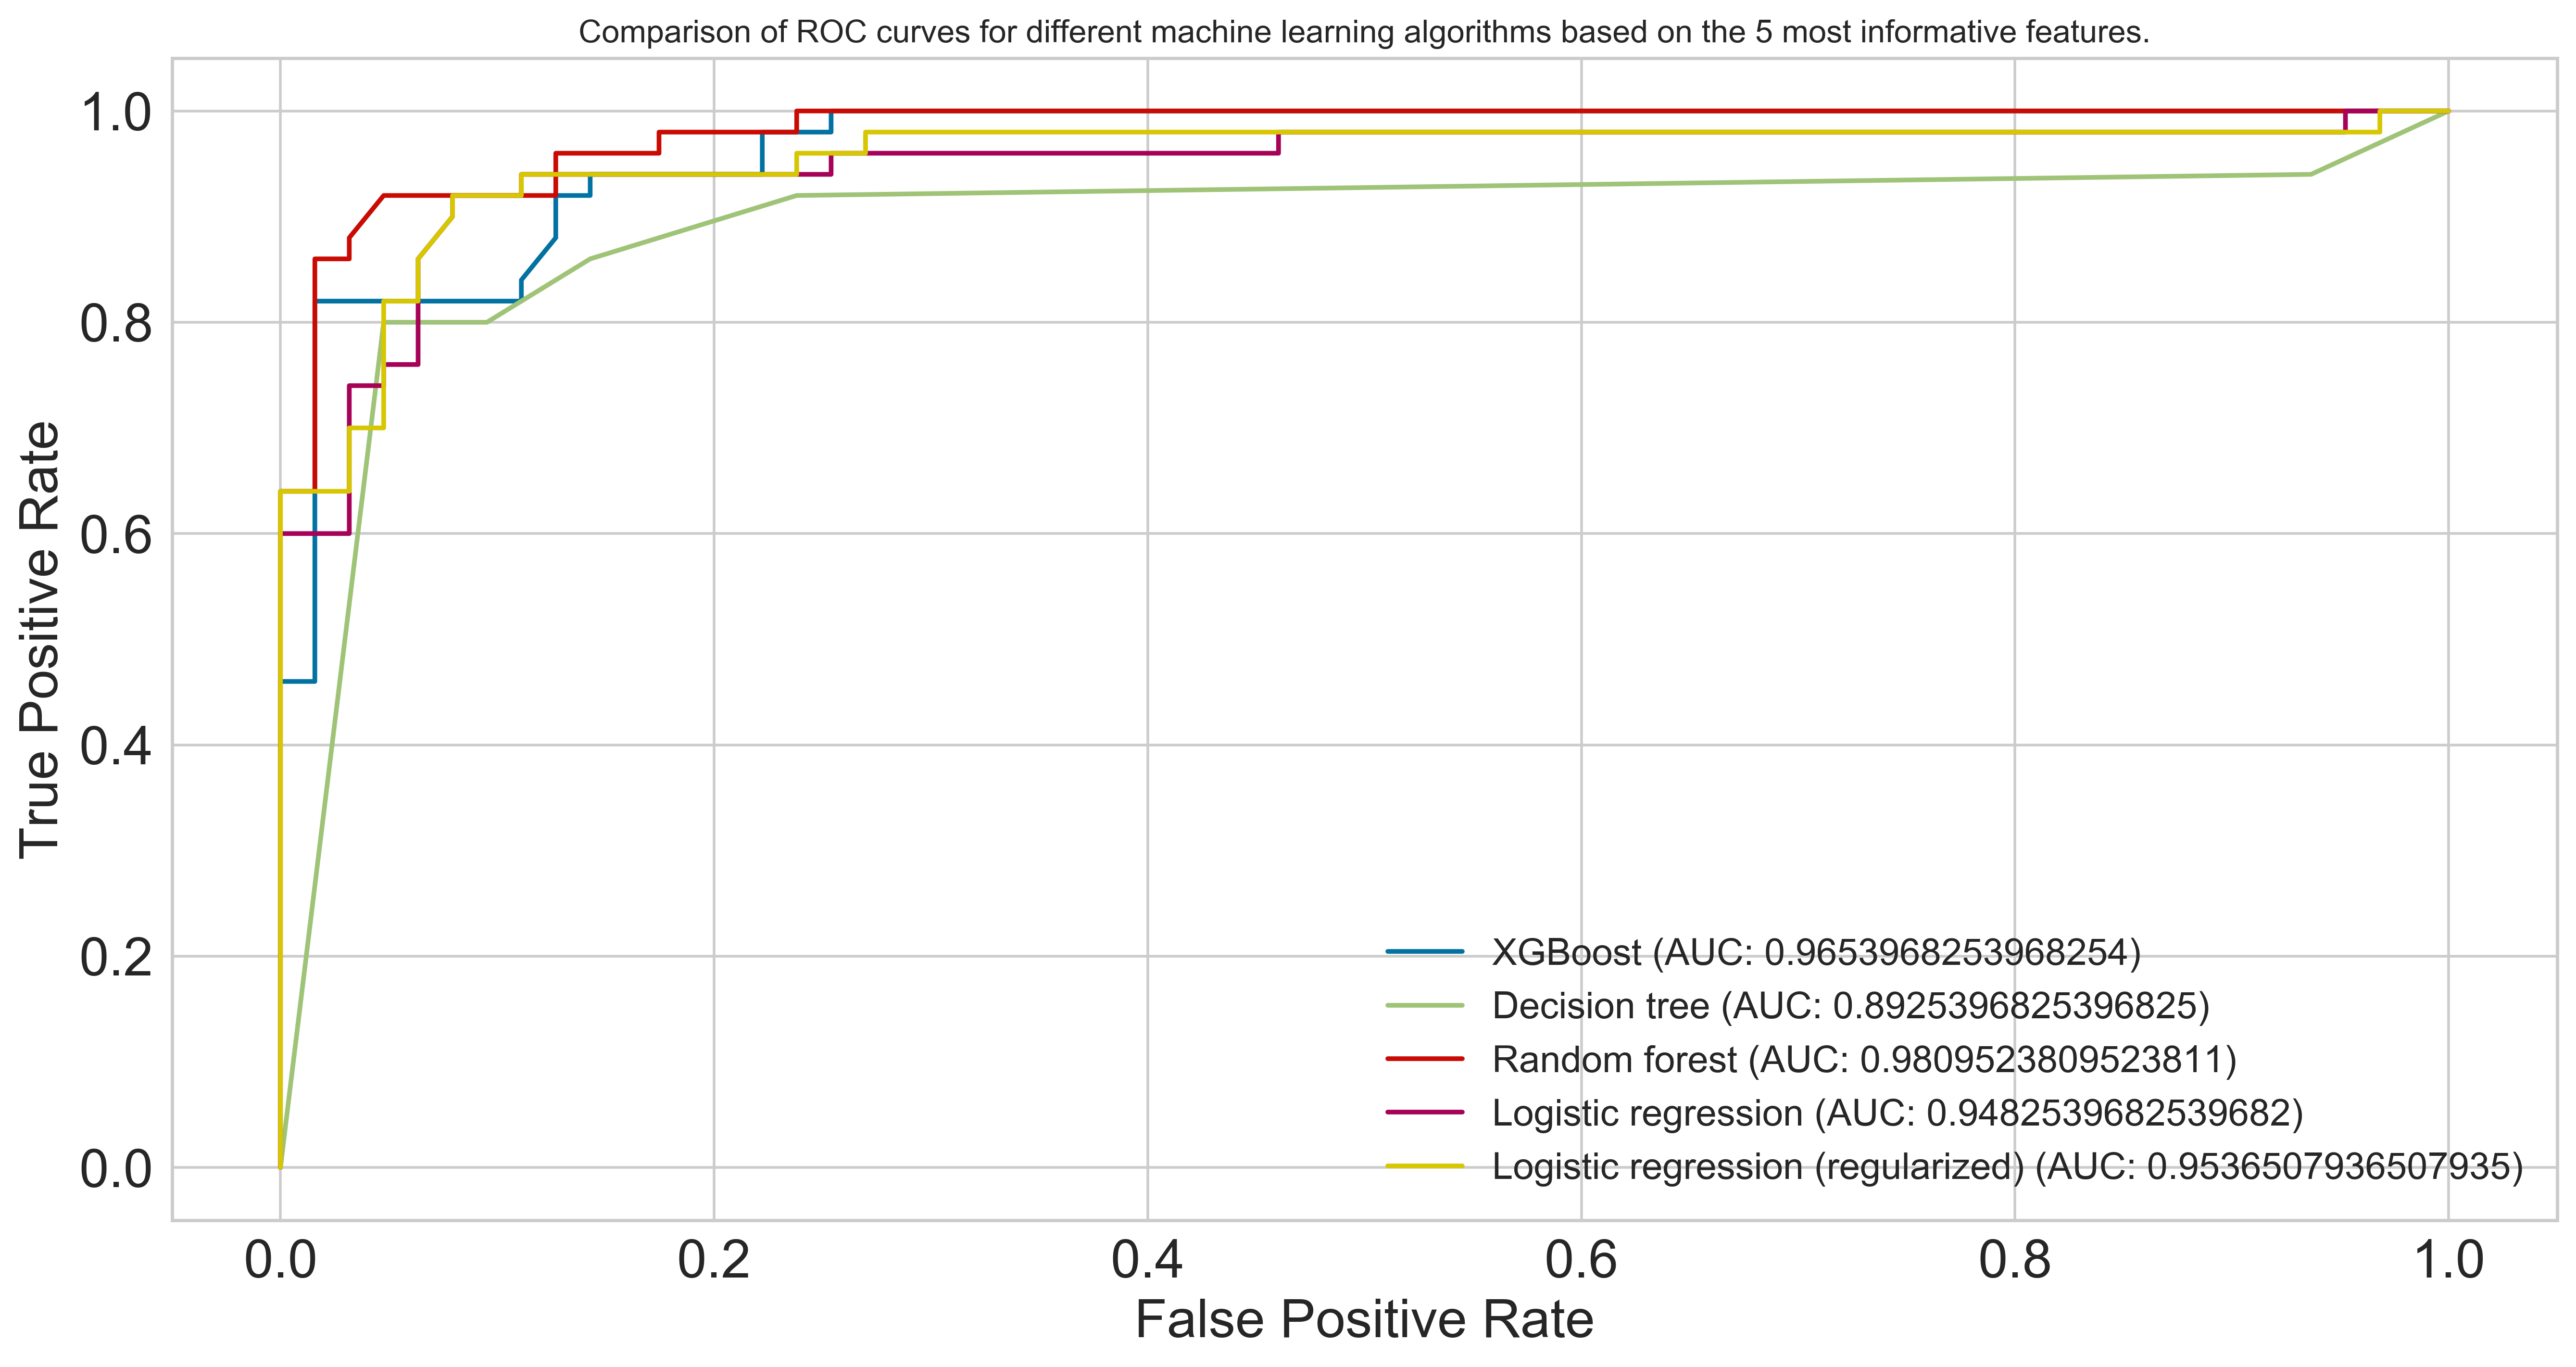

In [51]:
top_n = 5
plot_roc_for_models(
    models=models,
    x_train=x_train.iloc[:,:top_n],
    y_train=y_train,
    x_test=x_test.iloc[:,:top_n],
    y_test=y_test,
    title=f'Comparison of ROC curves for different machine learning algorithms based on the {top_n} most informative features.'
)

## Exercises

### Exercise 1

In the original paper (and as we have done above), `age` and `gender` variables are dropped as features. Re-run the analysis with these features. How might the inclusion of these variables affect the conclusions of the paper?

### Exercise 2

Using the data from Lecture 5's Linear Regression example, train and evaluate a classifier to determine whether a patient will survive >150 days.